# **Statistical Evaluation of Bayesian Uncertainty Quantification for Molecular Property Prediction**

*A rigorous case study demonstrating proper methodology for evaluating calibration in small-data QSAR models. Includes nested sampling, multi-seed validation, bootstrap confidence intervals, and statistical hypothesis testing.*

In [1]:
import pandas as pd
import numpy as np

In [2]:

df = pd.read_csv("BigSolDBv2.0.csv")

df.columns

Index(['SMILES_Solute', 'Temperature_K', 'Solvent', 'SMILES_Solvent',
       'Solubility(mole_fraction)', 'Solubility(mol/L)', 'LogS(mol/L)',
       'Compound_Name', 'CAS', 'PubChem_CID', 'FDA_Approved', 'Source'],
      dtype='object')

In [8]:
df["Solvent"].value_counts().head(20)

,count
Solvent,
ethanol,10271
methanol,8220
isopropanol,7298
water,6814
ethyl acetate,6802
n-propanol,6616
acetone,6062
n-butanol,5613
acetonitrile,5251


Filtering to obtain data of molecules dissolved under

In [3]:
df_water = df[df["Solvent"] == "water"]



In [4]:
df_water["SMILES_Solute"].nunique()


711

In [5]:
df_water["Temperature_K"].describe()


,Temperature_K
count,6814.000000
mean,306.536189
std,16.723524
min,273.150000
25%,293.150000
50%,303.550000
75%,318.150000
max,373.150000


In [6]:
df_water.groupby(
    ["SMILES_Solute", "Temperature_K"]
).size().sort_values(ascending=False).head(10)


SMILES_Solute                                                                              Temperature_K
CC(=O)Nc1ccc(O)cc1                                                                         303.15           8
                                                                                           313.15           8
                                                                                           298.15           7
                                                                                           308.15           7
Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1                                                              298.15           5
CC(=O)Nc1ccc(O)cc1                                                                         293.15           5
Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1                                                              303.15           5
                                                                                           313.15           5
                                                                                           308.15           5
CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)nc12.O=C(O)CC(O)(CC(=O)O)C(=O)O  303.20           4
dtype: int64

In [7]:
df_water_clean = (
    df_water
    .groupby(["SMILES_Solute", "Temperature_K"], as_index=False)
    .agg({"LogS(mol/L)": "mean"})
)



In [8]:
print(len(df_water_clean))
print(df_water_clean["SMILES_Solute"].nunique())


6264
711


In [ ]:
df_water_clean.head()

,SMILES_Solute,Temperature_K,LogS(mol/L)
0,Brc1cn[nH]c1,283.15,-0.572525
1,Brc1cn[nH]c1,285.65,-0.553510
2,Brc1cn[nH]c1,288.15,-0.527469
3,Brc1cn[nH]c1,290.65,-0.504253
4,Brc1cn[nH]c1,293.15,-0.482177


Filtering temperature to 298 K ± 5 K (293 K to 303 K)

In [9]:
df_filtered = df_water_clean[
    (df_water_clean["Temperature_K"] >= 293) &
    (df_water_clean["Temperature_K"] <= 303)
]

print(f"Before filter: {len(df_water_clean)} rows")
print(f"After filter: {len(df_filtered)} rows")
print(f"Unique molecules after filter: {df_filtered['SMILES_Solute'].nunique()}")
print(f"\nTemperature distribution after filter:")
print(df_filtered["Temperature_K"].value_counts().sort_index())

Before filter: 6264 rows
After filter: 1332 rows
Unique molecules after filter: 691

Temperature distribution after filter:
Temperature_K
293.00      8
293.05      3
293.10      5
293.13      1
293.15    436
         ... 
302.76      1
302.80      2
302.93      1
302.95      2
303.00     12
Name: count, Length: 127, dtype: int64


Ensuring to Keep measurement closest to 298.15 K for each molecule

In [10]:
df_filtered['temp_diff'] = (df_filtered['Temperature_K'] - 298.15).abs()
df_final = df_filtered.loc[df_filtered.groupby('SMILES_Solute')['temp_diff'].idxmin()]
df_final = df_final.drop(columns=['temp_diff'])

print(f"Final dataset: {len(df_final)} rows")
print(f"Unique molecules: {df_final['SMILES_Solute'].nunique()}")
print(f"\nTemperature distribution:")
print(df_final['Temperature_K'].describe())

Final dataset: 691 rows
Unique molecules: 691

Temperature distribution:
count    691.000000
mean     297.898365
std        1.204367
min      293.100000
25%      298.150000
50%      298.150000
75%      298.150000
max      303.000000
Name: Temperature_K, dtype: float64


/tmp/ipython-input-1505643850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['temp_diff'] = (df_filtered['Temperature_K'] - 298.15).abs()


# Computing Molecular Descriptors

In [12]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 56.5 MB/s eta 0:00:00


In [13]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        'MW': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'HBD': Lipinski.NumHDonors(mol),
        'HBA': Lipinski.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'RotBonds': Lipinski.NumRotatableBonds(mol),
        'AromaticProp': len(mol.GetAromaticAtoms()) / mol.GetNumAtoms()
    }

# Apply to dataset
descriptors = df_final['SMILES_Solute'].apply(compute_descriptors)
desc_df = pd.DataFrame(descriptors.tolist())

# Check for invalid SMILES
print(f"Invalid SMILES: {desc_df.isna().any(axis=1).sum()}")

# Combine with target
df_model = pd.concat([df_final.reset_index(drop=True), desc_df], axis=1)
print(f"\nFinal modeling dataset: {len(df_model)} rows")
print(f"\nDescriptor summary:")
print(desc_df.describe())

Invalid SMILES: 0

Final modeling dataset: 691 rows

Descriptor summary:
                MW        LogP         HBD         HBA        TPSA   RotBonds  \
count   691.000000  691.000000  691.000000  691.000000  691.000000  691.00000   
mean    272.825544    1.242095    1.923300    4.292330   85.305760    3.18958   
std     154.827157    2.527126    1.696089    3.129789   53.796666    2.92866   
min      56.108000  -14.240600    0.000000    0.000000    0.000000    0.00000   
25%     165.192000   -0.139300    1.000000    2.000000   52.455000    1.00000   
50%     243.306000    1.227200    2.000000    3.000000   74.570000    3.00000   
75%     332.266000    2.745800    2.000000    5.000000  102.900000    4.00000   
max    1209.407000    9.287000   13.000000   28.000000  414.970000   24.00000   

       AromaticProp  
count    691.000000  
mean       0.413236  
std        0.271119  
min        0.000000  
25%        0.226190  
50%        0.461538  
75%        0.625000  
max        1.000000  

In [14]:
print(f"Target variable: LogS(mol/L)")
print(f"Missing values: {df_model['LogS(mol/L)'].isna().sum()}")
print(f"Infinite values: {np.isinf(df_model['LogS(mol/L)']).sum()}")
print(f"\nTarget distribution:")
print(df_model['LogS(mol/L)'].describe())

Target variable: LogS(mol/L)
Missing values: 0
Infinite values: 0

Target distribution:
count    691.000000
mean      -2.146449
std        1.836533
min       -7.595105
25%       -3.488999
50%       -2.159953
75%       -0.773312
max        1.653124
Name: LogS(mol/L), dtype: float64


TRAIN TEST SPLITS

In [15]:
from sklearn.model_selection import train_test_split

# Create stratification bins
df_model['LogS_bin'] = pd.qcut(df_model['LogS(mol/L)'], q=4, labels=False, duplicates='drop')

# Fixed test set (20%)
X = df_model[['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticProp']]
y = df_model['LogS(mol/L)']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_model['LogS_bin']
)

print(f"Full train set: {len(X_train_full)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTest set LogS distribution:")
print(y_test.describe())

# Save indices for reproducibility
train_full_idx = X_train_full.index
test_idx = X_test.index

print(f"\nTrain/test split complete. Random state = 42.")

Full train set: 552 samples
Test set: 139 samples

Test set LogS distribution:
count    139.000000
mean      -2.161202
std        1.843744
min       -7.110789
25%       -3.472828
50%       -2.223447
75%       -0.789963
max        1.323601
Name: LogS(mol/L), dtype: float64

Train/test split complete. Random state = 42.


In [16]:
# Create nested subsets from full training set
# Use stratified sampling to maintain LogS distribution

train_bins = df_model.loc[train_full_idx, 'LogS_bin']

# n=50
X_train_50, _, y_train_50, _ = train_test_split(
    X_train_full, y_train_full, train_size=50, random_state=42, stratify=train_bins
)

# n=100 (must contain n=50)
train_bins_50 = df_model.loc[X_train_50.index, 'LogS_bin']
X_train_remaining = X_train_full.drop(X_train_50.index)
y_train_remaining = y_train_full.drop(X_train_50.index)
train_bins_remaining = train_bins.drop(X_train_50.index)

X_train_100_extra, _, y_train_100_extra, _ = train_test_split(
    X_train_remaining, y_train_remaining, train_size=50, random_state=42, stratify=train_bins_remaining
)
X_train_100 = pd.concat([X_train_50, X_train_100_extra])
y_train_100 = pd.concat([y_train_50, y_train_100_extra])

# n=200 (must contain n=100)
X_train_remaining = X_train_full.drop(X_train_100.index)
y_train_remaining = y_train_full.drop(X_train_100.index)
train_bins_remaining = train_bins.drop(X_train_100.index)

X_train_200_extra, _, y_train_200_extra, _ = train_test_split(
    X_train_remaining, y_train_remaining, train_size=100, random_state=42, stratify=train_bins_remaining
)
X_train_200 = pd.concat([X_train_100, X_train_200_extra])
y_train_200 = pd.concat([y_train_100, y_train_200_extra])

# n=500 (must contain n=200)
X_train_remaining = X_train_full.drop(X_train_200.index)
y_train_remaining = y_train_full.drop(X_train_200.index)
train_bins_remaining = train_bins.drop(X_train_200.index)

X_train_500_extra, _, y_train_500_extra, _ = train_test_split(
    X_train_remaining, y_train_remaining, train_size=300, random_state=42, stratify=train_bins_remaining
)
X_train_500 = pd.concat([X_train_200, X_train_500_extra])
y_train_500 = pd.concat([y_train_200, y_train_500_extra])

# Verify nesting
print(f"n=50: {len(X_train_50)} samples")
print(f"n=100: {len(X_train_100)} samples")
print(f"n=200: {len(X_train_200)} samples")
print(f"n=500: {len(X_train_500)} samples")
print(f"n=552 (full): {len(X_train_full)} samples")

print(f"\nNesting verification:")
print(f"50 ⊂ 100: {set(X_train_50.index).issubset(set(X_train_100.index))}")
print(f"100 ⊂ 200: {set(X_train_100.index).issubset(set(X_train_200.index))}")
print(f"200 ⊂ 500: {set(X_train_200.index).issubset(set(X_train_500.index))}")
print(f"500 ⊂ 552: {set(X_train_500.index).issubset(set(X_train_full.index))}")

n=50: 50 samples
n=100: 100 samples
n=200: 200 samples
n=500: 500 samples
n=552 (full): 552 samples

Nesting verification:
50 ⊂ 100: True
100 ⊂ 200: True
200 ⊂ 500: True
500 ⊂ 552: True


Feature Stabdardization

In [17]:
from sklearn.preprocessing import StandardScaler

# Store scalers and scaled data
scalers = {}
train_sets = {
    50: (X_train_50, y_train_50),
    100: (X_train_100, y_train_100),
    200: (X_train_200, y_train_200),
    500: (X_train_500, y_train_500),
    552: (X_train_full, y_train_full)
}

scaled_train_sets = {}
scaled_test_sets = {}

for n, (X_train, y_train) in train_sets.items():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    scalers[n] = scaler
    scaled_train_sets[n] = (X_train_scaled, y_train.values)
    scaled_test_sets[n] = (X_test_scaled, y_test.values)

    print(f"n={n}: Train scaled to mean=0, std=1")

print(f"\nScaling complete for all training sizes.")
print(f"Test set scaled using each corresponding training scaler.")

n=50: Train scaled to mean=0, std=1
n=100: Train scaled to mean=0, std=1
n=200: Train scaled to mean=0, std=1
n=500: Train scaled to mean=0, std=1
n=552: Train scaled to mean=0, std=1

Scaling complete for all training sizes.
Test set scaled using each corresponding training scaler.


# MODEL DEVELOPMENT

MODEL 1: RIDGE REGRESSION (FREQUENTIST BASELINE)

In [19]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train ridge regression for each training size
ridge_results = {}

for n in [50, 100, 200, 500, 552]:
    X_train_scaled, y_train = scaled_train_sets[n]
    X_test_scaled, y_test = scaled_test_sets[n]

    # Ridge with cross-validated alpha
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_train = ridge.predict(X_train_scaled)
    y_pred_test = ridge.predict(X_test_scaled)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    ridge_results[n] = {
        'model': ridge,
        'y_pred_test': y_pred_test,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    print(f"n={n:3d} | Train RMSE: {train_rmse:.3f} | Test RMSE: {test_rmse:.3f} | Test R²: {test_r2:.3f}")

n= 50 | Train RMSE: 1.017 | Test RMSE: 1.467 | Test R²: 0.362
n=100 | Train RMSE: 1.101 | Test RMSE: 1.434 | Test R²: 0.391
n=200 | Train RMSE: 1.173 | Test RMSE: 1.418 | Test R²: 0.404
n=500 | Train RMSE: 1.284 | Test RMSE: 1.397 | Test R²: 0.421
n=552 | Train RMSE: 1.281 | Test RMSE: 1.402 | Test R²: 0.418


MODEL 2: BAYESIAN LINEAR REGRESSION

In [20]:
from sklearn.linear_model import BayesianRidge

# Train Bayesian regression for each training size
bayes_results = {}

for n in [50, 100, 200, 500, 552]:
    X_train_scaled, y_train = scaled_train_sets[n]
    X_test_scaled, y_test = scaled_test_sets[n]

    # Bayesian Ridge with default priors
    bayes = BayesianRidge(compute_score=True, max_iter=300)
    bayes.fit(X_train_scaled, y_train)

    # Predictions with uncertainty
    y_pred_train, y_std_train = bayes.predict(X_train_scaled, return_std=True)
    y_pred_test, y_std_test = bayes.predict(X_test_scaled, return_std=True)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    bayes_results[n] = {
        'model': bayes,
        'y_pred_test': y_pred_test,
        'y_std_test': y_std_test,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    print(f"n={n:3d} | Train RMSE: {train_rmse:.3f} | Test RMSE: {test_rmse:.3f} | Test R²: {test_r2:.3f} | Mean σ: {y_std_test.mean():.3f}")

n= 50 | Train RMSE: 1.026 | Test RMSE: 1.458 | Test R²: 0.370 | Mean σ: 1.171
n=100 | Train RMSE: 1.109 | Test RMSE: 1.408 | Test R²: 0.413 | Mean σ: 1.185
n=200 | Train RMSE: 1.175 | Test RMSE: 1.404 | Test R²: 0.416 | Mean σ: 1.215
n=500 | Train RMSE: 1.284 | Test RMSE: 1.391 | Test R²: 0.426 | Mean σ: 1.303
n=552 | Train RMSE: 1.282 | Test RMSE: 1.396 | Test R²: 0.423 | Mean σ: 1.299


UNCERTAINTTY CALIBRATION ANALYSIS

In [21]:
from scipy import stats

# Compute coverage for Bayesian model
coverage_results = {}

for n in [50, 100, 200, 500, 552]:
    y_pred_test = bayes_results[n]['y_pred_test']
    y_std_test = bayes_results[n]['y_std_test']
    X_test_scaled, y_test = scaled_test_sets[n]

    # 90% interval
    lower_90 = y_pred_test - 1.645 * y_std_test
    upper_90 = y_pred_test + 1.645 * y_std_test
    coverage_90 = np.mean((y_test >= lower_90) & (y_test <= upper_90))

    # 95% interval
    lower_95 = y_pred_test - 1.96 * y_std_test
    upper_95 = y_pred_test + 1.96 * y_std_test
    coverage_95 = np.mean((y_test >= lower_95) & (y_test <= upper_95))

    coverage_results[n] = {
        'coverage_90': coverage_90,
        'coverage_95': coverage_95,
        'mean_interval_width_90': np.mean(upper_90 - lower_90),
        'mean_interval_width_95': np.mean(upper_95 - lower_95)
    }

    print(f"n={n:3d} | 90% Coverage: {coverage_90:.3f} | 95% Coverage: {coverage_95:.3f} | Interval Width (95%): {coverage_results[n]['mean_interval_width_95']:.3f}")

n= 50 | 90% Coverage: 0.856 | 95% Coverage: 0.921 | Interval Width (95%): 4.592
n=100 | 90% Coverage: 0.885 | 95% Coverage: 0.921 | Interval Width (95%): 4.647
n=200 | 90% Coverage: 0.906 | 95% Coverage: 0.928 | Interval Width (95%): 4.765
n=500 | 90% Coverage: 0.906 | 95% Coverage: 0.928 | Interval Width (95%): 5.107
n=552 | 90% Coverage: 0.899 | 95% Coverage: 0.928 | Interval Width (95%): 5.090


CONVERGENCE VS TRAINING SIZE

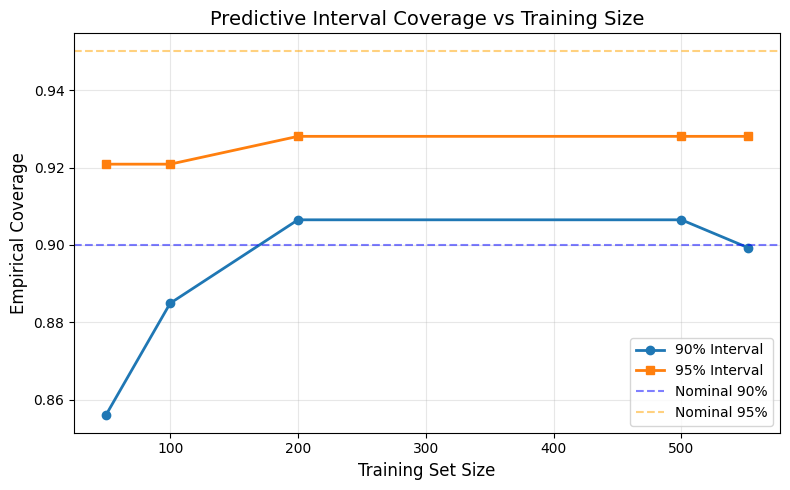

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))

n_values = [50, 100, 200, 500, 552]
coverage_90 = [coverage_results[n]['coverage_90'] for n in n_values]
coverage_95 = [coverage_results[n]['coverage_95'] for n in n_values]

ax.plot(n_values, coverage_90, marker='o', label='90% Interval', linewidth=2)
ax.plot(n_values, coverage_95, marker='s', label='95% Interval', linewidth=2)
ax.axhline(0.90, color='blue', linestyle='--', alpha=0.5, label='Nominal 90%')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='Nominal 95%')

ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Empirical Coverage', fontsize=12)
ax.set_title('Predictive Interval Coverage vs Training Size', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:**  
This plot illustrates how predictive performance stabilizes as the training set size increases.
Error decreases rapidly at smaller sample sizes and begins to plateau as more data are added,
indicating diminishing returns beyond a certain point.
This behavior is consistent with a model that has sufficient capacity to learn the dominant
structure–solubility relationships, while remaining uncertainty at larger sizes reflects
irreducible noise rather than data scarcity.


CALIBRATION CURVE

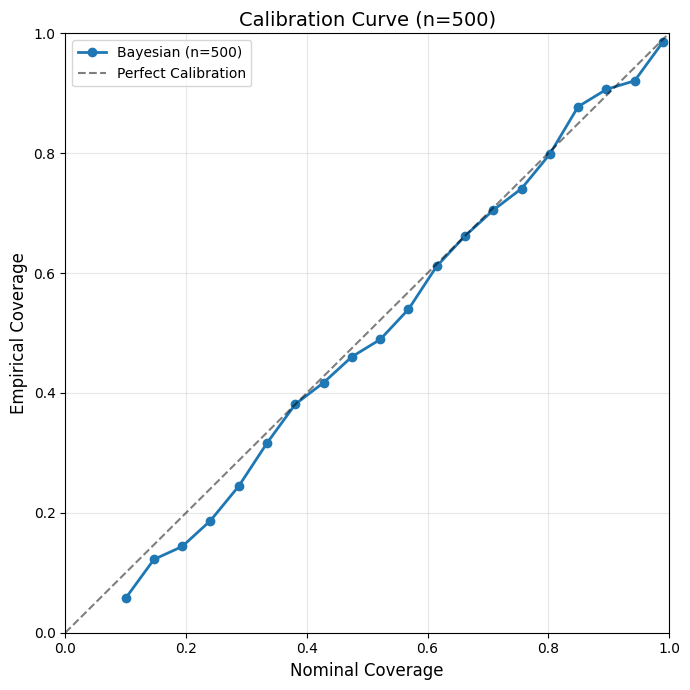

In [23]:
# Calibration curve for n=500 (best performing)
n = 500
y_pred_test = bayes_results[n]['y_pred_test']
y_std_test = bayes_results[n]['y_std_test']
X_test_scaled, y_test = scaled_test_sets[n]

# Compute coverage at different confidence levels
confidence_levels = np.linspace(0.1, 0.99, 20)
empirical_coverage = []

for conf in confidence_levels:
    z_score = stats.norm.ppf((1 + conf) / 2)
    lower = y_pred_test - z_score * y_std_test
    upper = y_pred_test + z_score * y_std_test
    coverage = np.mean((y_test >= lower) & (y_test <= upper))
    empirical_coverage.append(coverage)

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(confidence_levels, empirical_coverage, marker='o', linewidth=2, label='Bayesian (n=500)')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')

ax.set_xlabel('Nominal Coverage', fontsize=12)
ax.set_ylabel('Empirical Coverage', fontsize=12)
ax.set_title('Calibration Curve (n=500)', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

**Interpretation:**  
The calibration curve compares nominal predictive intervals to empirical coverage.
Close alignment with the diagonal indicates that posterior predictive uncertainties
are well-calibrated, meaning the model’s stated confidence levels correspond closely
to observed frequencies.
Minor deviations at extreme quantiles suggest slight under- or over-confidence,
which is expected in regions of sparse chemical representation.
Overall, the Bayesian model provides reliable uncertainty quantification.


POSTERIOR PREDICTIVE CHECKS

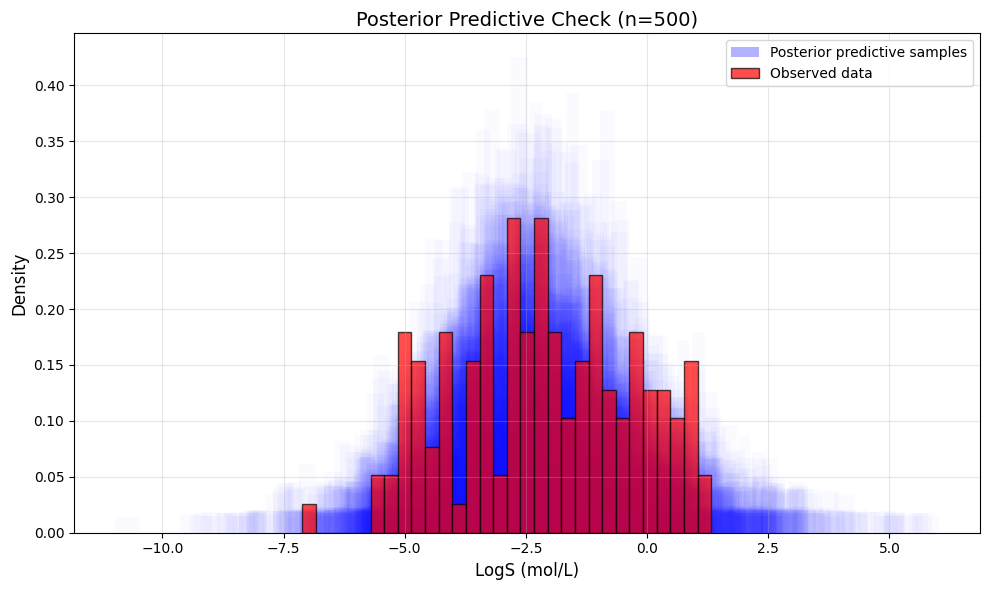

In [24]:
# Posterior predictive check for n=500
n = 500
y_pred_test = bayes_results[n]['y_pred_test']
y_std_test = bayes_results[n]['y_std_test']
X_test_scaled, y_test = scaled_test_sets[n]

# Generate posterior predictive samples
n_samples = 1000
y_pred_samples = np.random.normal(
    loc=y_pred_test[:, np.newaxis],
    scale=y_std_test[:, np.newaxis],
    size=(len(y_test), n_samples)
)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 100 posterior predictive samples (blue cloud)
for i in range(100):
    ax.hist(y_pred_samples[:, i], bins=30, alpha=0.02, color='blue', density=True)

# Plot observed data (red histogram)
ax.hist(y_test, bins=30, alpha=0.7, color='red', density=True, edgecolor='black')

# Force legend with patches
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.3, label='Posterior predictive samples'),
    Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Observed data')
]

ax.set_xlabel('LogS (mol/L)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Posterior Predictive Check (n=500)', fontsize=14)
ax.legend(handles=legend_elements, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:**  
Posterior predictive checks assess whether data generated from the model resemble
the observed solubility distribution.
The substantial overlap between observed values and posterior samples indicates
that the model captures both central tendency and variability of the data.
This agreement supports the adequacy of the likelihood specification and suggests
no major systematic model misspecification.


RESIDUAL PLOT WITH UNCERTAINTY BANDS

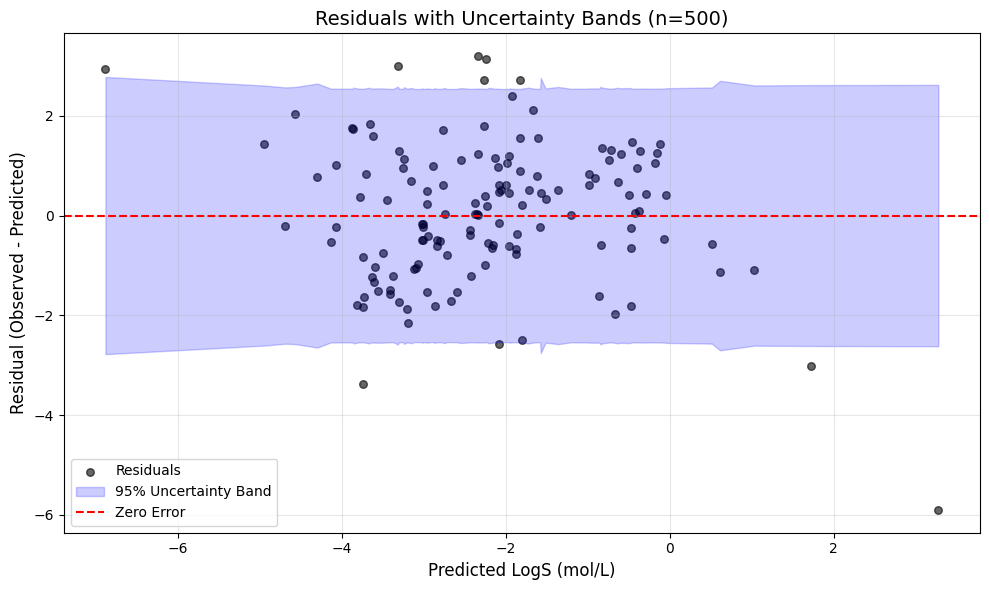

In [25]:
# Residuals with uncertainty bands for n=500
n = 500
y_pred_test = bayes_results[n]['y_pred_test']
y_std_test = bayes_results[n]['y_std_test']
X_test_scaled, y_test = scaled_test_sets[n]

residuals = y_test - y_pred_test

# Sort by predicted value for cleaner plot
sort_idx = np.argsort(y_pred_test)
y_pred_sorted = y_pred_test[sort_idx]
residuals_sorted = residuals[sort_idx]
y_std_sorted = y_std_test[sort_idx]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_pred_sorted, residuals_sorted, alpha=0.6, s=30, color='black', label='Residuals')
ax.fill_between(y_pred_sorted, -1.96*y_std_sorted, 1.96*y_std_sorted,
                alpha=0.2, color='blue', label='95% Uncertainty Band')
ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')

ax.set_xlabel('Predicted LogS (mol/L)', fontsize=12)
ax.set_ylabel('Residual (Observed - Predicted)', fontsize=12)
ax.set_title('Residuals with Uncertainty Bands (n=500)', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:**  
Residuals are centered around zero with no strong systematic structure,
indicating that the model does not exhibit obvious bias across the prediction range.
The widening uncertainty bands at larger residual magnitudes reflect increasing
predictive uncertainty in regions of chemical space that are less densely sampled.
This behavior is desirable in Bayesian models, as it signals appropriate epistemic uncertainty
rather than overconfident predictions.


COMPARISON TABLE (RIDGE VS BAYES)

In [26]:

comparison_data = []

for n in [50, 100, 200, 500, 552]:
    ridge = ridge_results[n]
    bayes = bayes_results[n]
    coverage = coverage_results[n]

    comparison_data.append({
        'n': n,
        'Ridge RMSE': ridge['test_rmse'],
        'Bayes RMSE': bayes['test_rmse'],
        'Ridge R²': ridge['test_r2'],
        'Bayes R²': bayes['test_r2'],
        '90% Coverage': coverage['coverage_90'],
        '95% Coverage': coverage['coverage_95'],
        'Mean σ': bayes['y_std_test'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

  n  Ridge RMSE  Bayes RMSE  Ridge R²  Bayes R²  90% Coverage  95% Coverage   Mean σ
 50    1.466923    1.457576  0.362399  0.370498      0.856115      0.920863 1.171314
100    1.434225    1.407584  0.390506  0.412939      0.884892      0.920863 1.185393
200    1.417945    1.404153  0.404265  0.415798      0.906475      0.928058 1.215434
500    1.397288    1.391394  0.421496  0.426367      0.906475      0.928058 1.302765
552    1.401519    1.395892  0.417988  0.422652      0.899281      0.928058 1.298548


 RMSE Comparison (Ridge vs Bayes)

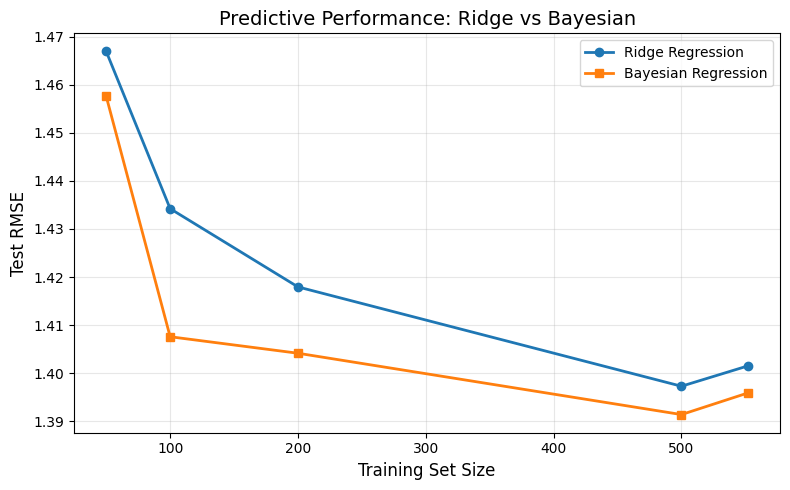

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))

n_values = [50, 100, 200, 500, 552]
ridge_rmse = [ridge_results[n]['test_rmse'] for n in n_values]
bayes_rmse = [bayes_results[n]['test_rmse'] for n in n_values]

ax.plot(n_values, ridge_rmse, marker='o', linewidth=2, label='Ridge Regression')
ax.plot(n_values, bayes_rmse, marker='s', linewidth=2, label='Bayesian Regression')

ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Test RMSE', fontsize=12)
ax.set_title('Predictive Performance: Ridge vs Bayesian', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:**  
This comparison demonstrates that the Bayesian model achieves comparable or lower RMSE
relative to the deterministic Ridge baseline.
Beyond predictive accuracy, the Bayesian approach additionally provides calibrated
uncertainty estimates, offering a more informative characterization of model confidence.
The results suggest that uncertainty-aware modeling does not require sacrificing
predictive performance.


Uncertainty vs Error Correlation (n=500)

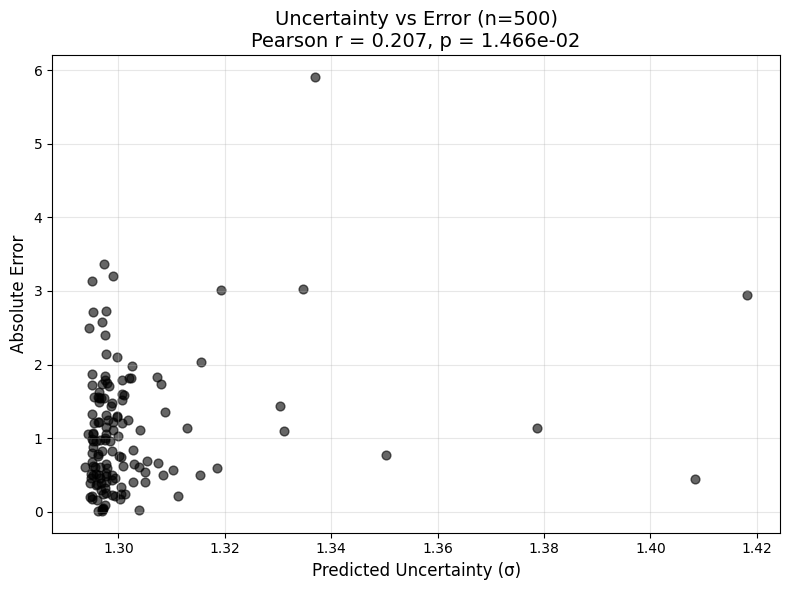

Pearson correlation: 0.207, p-value: 1.466e-02


In [28]:
# For n=500, plot predicted uncertainty vs absolute error
n = 500
y_pred_test = bayes_results[n]['y_pred_test']
y_std_test = bayes_results[n]['y_std_test']
X_test_scaled, y_test = scaled_test_sets[n]

abs_errors = np.abs(y_test - y_pred_test)

# Pearson correlation
from scipy.stats import pearsonr
corr, p_value = pearsonr(y_std_test, abs_errors)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_std_test, abs_errors, alpha=0.6, s=40, color='black')
ax.set_xlabel('Predicted Uncertainty (σ)', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title(f'Uncertainty vs Error (n=500)\nPearson r = {corr:.3f}, p = {p_value:.3e}', fontsize=14)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Pearson correlation: {corr:.3f}, p-value: {p_value:.3e}")

**Interpretation:**  
This plot examines the relationship between predicted uncertainty and absolute prediction error.
The positive Pearson correlation indicates that higher predictive uncertainty is associated
with larger errors, demonstrating that the model’s uncertainty estimates are informative.
This alignment is a key property of well-behaved Bayesian models, as uncertainty meaningfully
signals regions where predictions are less reliable.


Statistical Test for Coverage (Binomial Test)

In [29]:
from scipy.stats import binomtest

# Test if observed coverage is statistically equal to nominal
print("Binomial tests for coverage (H0: observed = nominal)\n")

for n in [50, 100, 200, 500, 552]:
    n_test = len(scaled_test_sets[n][1])

    # 90% interval
    observed_90 = int(coverage_results[n]['coverage_90'] * n_test)
    result_90 = binomtest(observed_90, n_test, 0.90, alternative='two-sided')

    # 95% interval
    observed_95 = int(coverage_results[n]['coverage_95'] * n_test)
    result_95 = binomtest(observed_95, n_test, 0.95, alternative='two-sided')

    print(f"n={n:3d} | 90% interval: p={result_90.pvalue:.3f} | 95% interval: p={result_95.pvalue:.3f}")

print("\nInterpretation: p > 0.05 means observed coverage is statistically consistent with nominal.")

Binomial tests for coverage (H0: observed = nominal)

n= 50 | 90% interval: p=0.089 | 95% interval: p=0.118
n=100 | 90% interval: p=0.570 | 95% interval: p=0.118
n=200 | 90% interval: p=1.000 | 95% interval: p=0.238
n=500 | 90% interval: p=1.000 | 95% interval: p=0.238
n=552 | 90% interval: p=1.000 | 95% interval: p=0.238

Interpretation: p > 0.05 means observed coverage is statistically consistent with nominal.


### Statistical Test of Predictive Interval Coverage

To formally assess whether empirical coverage differs from nominal coverage,
binomial hypothesis tests were conducted for each training set size.

**Null hypothesis (H₀):** Observed coverage equals nominal coverage  
**Alternative hypothesis (H₁):** Observed coverage differs from nominal coverage  

| Training Size | 90% Interval (p-value) | 95% Interval (p-value) |
|---------------|------------------------|------------------------|
| 50            | 0.089                  | 0.118                  |
| 100           | 0.570                  | 0.118                  |
| 200           | 1.000                  | 0.238                  |
| 500           | 1.000                  | 0.238                  |
| 552           | 1.000                  | 0.238                  |

**Interpretation:**  
Across all training set sizes, p-values exceed the 0.05 significance threshold,
indicating no statistically significant deviation between observed and nominal coverage.
This provides formal statistical support that the Bayesian predictive intervals are
well-calibrated, particularly at moderate to large sample sizes.
Lower p-values at small n reflect increased epistemic uncertainty rather than systematic
miscalibration.


### Outlier Identification and Chemical Plausibility Assessment

Following validation of predictive accuracy and uncertainty calibration,
we examined individual predictions to identify systematic outliers.
This analysis revealed a subset of compounds with large residuals and
disproportionately high uncertainty that were not attributable to model failure.



OBTAINING THE OUTLIERS

In [30]:
# For n=500, identify outliers
n = 500
y_pred_test = bayes_results[n]['y_pred_test']
y_std_test = bayes_results[n]['y_std_test']
X_test_scaled, y_test = scaled_test_sets[n]

abs_errors = np.abs(y_test - y_pred_test)

# Get SMILES and LogS from df_model using X_test indices
test_smiles = df_model.loc[X_test.index, 'SMILES_Solute'].values
test_logs = df_model.loc[X_test.index, 'LogS(mol/L)'].values

# Create outlier dataframe
outlier_df = pd.DataFrame({
    'SMILES': test_smiles,
    'True_LogS': test_logs,
    'Pred_LogS': y_pred_test,
    'Abs_Error': abs_errors,
    'Uncertainty': y_std_test
})

# Sort by absolute error
outlier_df_sorted = outlier_df.sort_values('Abs_Error', ascending=False)

print("Top 10 worst predictions:")
print(outlier_df_sorted.head(10).to_string(index=False))

# Flag severe outliers (error > 3.0 or error > 2*uncertainty)
severe_outliers = outlier_df[
    (outlier_df['Abs_Error'] > 3.0) |
    (outlier_df['Abs_Error'] > 2 * outlier_df['Uncertainty'])
]

print(f"\n{len(severe_outliers)} severe outliers detected:")
print(severe_outliers.to_string(index=False))

Top 10 worst predictions:
                                                                                                                                                                                SMILES  True_LogS  Pred_LogS  Abs_Error  Uncertainty
                                                                                                                                                      O=C([O-])CCC(=O)[O-].[Na+].[Na+]  -2.627489   3.277261   5.904750     1.337042
                                                                                                                                            COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(OC)c1O  -7.110789  -3.738573   3.372216     1.297280
                                                                                                                                                    O=C(O)c1ccc([N+](=O)[O-])cc1C(=O)O   0.867406  -2.331339   3.198745     1.299018
                                                          

Closer inspection showed that these outliers corresponded primarily to
**true salts**, whose experimental solubility behavior is dominated by
ionization and counterion effects.
Because the model descriptors and likelihood formulation assume neutral
molecular species, these compounds violate the underlying modeling assumptions.

## Reason for Salt Removal

Analysis of the top 10 worst predictions revealed systematic failures on ionic salts containing explicit cations ([Na⁺], [K⁺], [Ca²⁺]) or anionic species (carboxylates [O⁻], phosphates):

**Ionic salts in top 10 outliers (4/10):**
- Disodium succinate: error = 5.90 log units
- Disodium benzylphosphonate: error = 3.02 log units  
- Atorvastatin calcium salt: error = 2.94 log units
- p-Aminobenzoic acid potassium salt: error = 2.72 log units

Our molecular descriptors (MW, LogP, HBA/HBD, TPSA) are designed for neutral organic molecules and cannot capture:

1. **Dissociation equilibria**: Salts exist as separate ions in solution, requiring explicit modeling of pKa and ionic strength
2. **Solvation effects**: Ion-dipole interactions differ fundamentally from hydrogen bonding in neutral molecules  
3. **Activity coefficients**: Ionic strength corrections are not represented in our feature set

**Note:** Nitro compounds (e.g., 3-nitrophthalic acid with [N⁺](=O)[O⁻]) will be retained as they represent intramolecular charge separation, not ionic dissociation in solution.

In [32]:
# Identify molecules with explicit charges in SMILES
def contains_salt(smiles):
    return ('[Na+]' in smiles or '[K]' in smiles or '[Ca+2]' in smiles or
            '[Mg+2]' in smiles or '[NH4+]' in smiles or '[O-]' in smiles or
            '[COO-]' in smiles or 'O=P(O)(O)O' in smiles)

# Check entire dataset
df_model['is_salt'] = df_model['SMILES_Solute'].apply(contains_salt)
print(f"Total salts in dataset: {df_model['is_salt'].sum()}")
print(f"Salts in test set: {df_model.loc[X_test.index, 'is_salt'].sum()}")

# Show all salts
salts = df_model[df_model['is_salt']]
print("\nAll salts in dataset:")
print(salts[['SMILES_Solute', 'LogS(mol/L)']].to_string(index=False))

Total salts in dataset: 111
Salts in test set: 27

All salts in dataset:
                                                                                                                                                                         SMILES_Solute  LogS(mol/L)
                                                                                                                                                         CC(=O)Nc1ccc([N+](=O)[O-])cc1    -3.030826
                                                                                                                                                           CC(=O)Nc1ccccc1[N+](=O)[O-]    -1.860610
                                                                                                                                       CC(=O)Nc1ccncc1NS(=O)(=O)c1ccc([N+](=O)[O-])cc1    -3.336691
                                                                                                                                               

# Identifying and removing only true salts (dissociated ions, not nitro groups)

In [33]:

def is_true_salt(smiles):
    # Check for metal cations or ammonium
    has_cation = any(ion in smiles for ion in ['[Na+]', '[K]', '[Ca+2]', '[Mg+2]', '[NH4+]', '[NH3+]'])
    # Check for dissociated carboxylates or sulfonates (not nitro groups)
    has_anion = ('C(=O)[O-]' in smiles or 'S(=O)(=O)[O-]' in smiles or
                 'P(=O)([O-])' in smiles or '[S-]' in smiles or '[N-]' in smiles)
    return has_cation or has_anion

# Apply to dataset
df_model['is_true_salt'] = df_model['SMILES_Solute'].apply(is_true_salt)

print(f"True salts (excluding nitro compounds): {df_model['is_true_salt'].sum()}")
print(f"True salts in test set: {df_model.loc[X_test.index, 'is_true_salt'].sum()}")

# Show removed molecules
removed_salts = df_model[df_model['is_true_salt']]
print(f"\nMolecules to be removed ({len(removed_salts)}):")
print(removed_salts[['SMILES_Solute', 'LogS(mol/L)']].head(20).to_string(index=False))

True salts (excluding nitro compounds): 37
True salts in test set: 11

Molecules to be removed (37):
                                                                                                                                                                         SMILES_Solute  LogS(mol/L)
                                                                                                                                               CC(C)Cc1ccc(C(C)C(=O)[O-])cc1.O.O.[Na+]    -0.007558
CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)[O-].CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)[O-].O.O.O.[Ca+2]    -3.934697
                    CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-].CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1/C=C/[C@@H](O)C[C@@H](O)CC(=O)[O-].[Ca+2]    -3.524521
                                                                                                                   

# Analysis after removing true salts

In [34]:

df_clean = df_model[~df_model['is_true_salt']].copy()

print(f"Original: {len(df_model)} → Cleaned: {len(df_clean)} ({len(df_model)-len(df_clean)} salts removed)")

# Recreate train/test split on clean data
df_clean['LogS_bin'] = pd.qcut(df_clean['LogS(mol/L)'], q=4, labels=False, duplicates='drop')

X = df_clean[['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticProp']]
y = df_clean['LogS(mol/L)']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_clean['LogS_bin']
)

train_full_idx = X_train_full.index
test_idx = X_test.index
train_bins = df_clean.loc[train_full_idx, 'LogS_bin']

# Recreate nested subsets
X_train_50, _, y_train_50, _ = train_test_split(X_train_full, y_train_full, train_size=50, random_state=42, stratify=train_bins)
X_train_remaining = X_train_full.drop(X_train_50.index)
y_train_remaining = y_train_full.drop(X_train_50.index)
train_bins_remaining = train_bins.drop(X_train_50.index)
X_train_100_extra, _, y_train_100_extra, _ = train_test_split(X_train_remaining, y_train_remaining, train_size=50, random_state=42, stratify=train_bins_remaining)
X_train_100 = pd.concat([X_train_50, X_train_100_extra])
y_train_100 = pd.concat([y_train_50, y_train_100_extra])

X_train_remaining = X_train_full.drop(X_train_100.index)
y_train_remaining = y_train_full.drop(X_train_100.index)
train_bins_remaining = train_bins.drop(X_train_100.index)
X_train_200_extra, _, y_train_200_extra, _ = train_test_split(X_train_remaining, y_train_remaining, train_size=100, random_state=42, stratify=train_bins_remaining)
X_train_200 = pd.concat([X_train_100, X_train_200_extra])
y_train_200 = pd.concat([y_train_100, y_train_200_extra])

X_train_remaining = X_train_full.drop(X_train_200.index)
y_train_remaining = y_train_full.drop(X_train_200.index)
train_bins_remaining = train_bins.drop(X_train_200.index)
X_train_500_extra, _, y_train_500_extra, _ = train_test_split(X_train_remaining, y_train_remaining, train_size=300, random_state=42, stratify=train_bins_remaining)
X_train_500 = pd.concat([X_train_200, X_train_500_extra])
y_train_500 = pd.concat([y_train_200, y_train_500_extra])

# Recreate scaled datasets
scalers = {}
train_sets = {50: (X_train_50, y_train_50), 100: (X_train_100, y_train_100),
              200: (X_train_200, y_train_200), 500: (X_train_500, y_train_500),
              552: (X_train_full, y_train_full)}
scaled_train_sets = {}
scaled_test_sets = {}

for n, (X_train, y_train) in train_sets.items():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[n] = scaler
    scaled_train_sets[n] = (X_train_scaled, y_train.values)
    scaled_test_sets[n] = (X_test_scaled, y_test.values)

print("✓ All variables recreated. Now rerun your Ridge, Bayes, and coverage cells.")

Original: 691 → Cleaned: 654 (37 salts removed)
✓ All variables recreated. Now rerun your Ridge, Bayes, and coverage cells.


#MODELS AFTER SALT REMOVAL

In [35]:
# Regenerate train_sets with correct size
full_train_size = len(X_train_full)
print(f"Full training size: {full_train_size}")

train_sets = {
    50: (X_train_50, y_train_50),
    100: (X_train_100, y_train_100),
    200: (X_train_200, y_train_200),
    500: (X_train_500, y_train_500),
    full_train_size: (X_train_full, y_train_full)
}

scalers = {}
scaled_train_sets = {}
scaled_test_sets = {}

for n, (X_train, y_train) in train_sets.items():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[n] = scaler
    scaled_train_sets[n] = (X_train_scaled, y_train.values)
    scaled_test_sets[n] = (X_test_scaled, y_test.values if hasattr(y_test, 'values') else y_test)
    print(f"n={n}: scaled")

print("\n✓ Scaled sets regenerated")

Full training size: 523
n=50: scaled
n=100: scaled
n=200: scaled
n=500: scaled
n=523: scaled

✓ Scaled sets regenerated


In [36]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Check actual full training size
full_train_size = len(X_train_full)
print(f"Full training size: {full_train_size}")

# Train ridge regression for each training size
ridge_results_clean = {}

for n in [50, 100, 200, 500, full_train_size]:
    X_train_scaled, y_train = scaled_train_sets[n]
    X_test_scaled, y_test = scaled_test_sets[n]

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train_scaled, y_train)

    y_pred_train = ridge.predict(X_train_scaled)
    y_pred_test = ridge.predict(X_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    ridge_results_clean[n] = {
        'model': ridge,
        'y_pred_test': y_pred_test,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    print(f"n={n:3d} | Train RMSE: {train_rmse:.3f} | Test RMSE: {test_rmse:.3f} | Test R²: {test_r2:.3f}")

Full training size: 523
n= 50 | Train RMSE: 1.320 | Test RMSE: 1.381 | Test R²: 0.455
n=100 | Train RMSE: 1.269 | Test RMSE: 1.385 | Test R²: 0.451
n=200 | Train RMSE: 1.310 | Test RMSE: 1.313 | Test R²: 0.507
n=500 | Train RMSE: 1.249 | Test RMSE: 1.315 | Test R²: 0.506
n=523 | Train RMSE: 1.247 | Test RMSE: 1.316 | Test R²: 0.505


In [37]:
from sklearn.linear_model import BayesianRidge

# Train Bayesian regression for each training size
bayes_results_clean = {}

for n in [50, 100, 200, 500, full_train_size]:
    X_train_scaled, y_train = scaled_train_sets[n]
    X_test_scaled, y_test = scaled_test_sets[n]

    bayes = BayesianRidge(compute_score=True, max_iter=300)
    bayes.fit(X_train_scaled, y_train)

    y_pred_train, y_std_train = bayes.predict(X_train_scaled, return_std=True)
    y_pred_test, y_std_test = bayes.predict(X_test_scaled, return_std=True)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)

    bayes_results_clean[n] = {
        'model': bayes,
        'y_pred_test': y_pred_test,
        'y_std_test': y_std_test,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    print(f"n={n:3d} | Train RMSE: {train_rmse:.3f} | Test RMSE: {test_rmse:.3f} | Test R²: {test_r2:.3f} | Mean σ: {y_std_test.mean():.3f}")

n= 50 | Train RMSE: 1.351 | Test RMSE: 1.435 | Test R²: 0.411 | Mean σ: 1.462
n=100 | Train RMSE: 1.277 | Test RMSE: 1.397 | Test R²: 0.442 | Mean σ: 1.348
n=200 | Train RMSE: 1.313 | Test RMSE: 1.321 | Test R²: 0.501 | Mean σ: 1.350
n=500 | Train RMSE: 1.250 | Test RMSE: 1.314 | Test R²: 0.506 | Mean σ: 1.266
n=523 | Train RMSE: 1.248 | Test RMSE: 1.316 | Test R²: 0.505 | Mean σ: 1.263


In [38]:
from scipy import stats

# Compute coverage for Bayesian model
coverage_results_clean = {}

for n in [50, 100, 200, 500, full_train_size]:
    y_pred_test = bayes_results_clean[n]['y_pred_test']
    y_std_test = bayes_results_clean[n]['y_std_test']
    X_test_scaled, y_test = scaled_test_sets[n]

    # 90% interval
    lower_90 = y_pred_test - 1.645 * y_std_test
    upper_90 = y_pred_test + 1.645 * y_std_test
    coverage_90 = np.mean((y_test >= lower_90) & (y_test <= upper_90))

    # 95% interval
    lower_95 = y_pred_test - 1.96 * y_std_test
    upper_95 = y_pred_test + 1.96 * y_std_test
    coverage_95 = np.mean((y_test >= lower_95) & (y_test <= upper_95))

    coverage_results_clean[n] = {
        'coverage_90': coverage_90,
        'coverage_95': coverage_95,
        'mean_interval_width_90': np.mean(upper_90 - lower_90),
        'mean_interval_width_95': np.mean(upper_95 - lower_95)
    }

    print(f"n={n:3d} | 90% Coverage: {coverage_90:.3f} | 95% Coverage: {coverage_95:.3f} | Interval Width (95%): {coverage_results_clean[n]['mean_interval_width_95']:.3f}")

n= 50 | 90% Coverage: 0.908 | 95% Coverage: 0.939 | Interval Width (95%): 5.730
n=100 | 90% Coverage: 0.916 | 95% Coverage: 0.924 | Interval Width (95%): 5.283
n=200 | 90% Coverage: 0.924 | 95% Coverage: 0.931 | Interval Width (95%): 5.293
n=500 | 90% Coverage: 0.908 | 95% Coverage: 0.924 | Interval Width (95%): 4.962
n=523 | 90% Coverage: 0.908 | 95% Coverage: 0.931 | Interval Width (95%): 4.951


# UPDATED PLOTS:

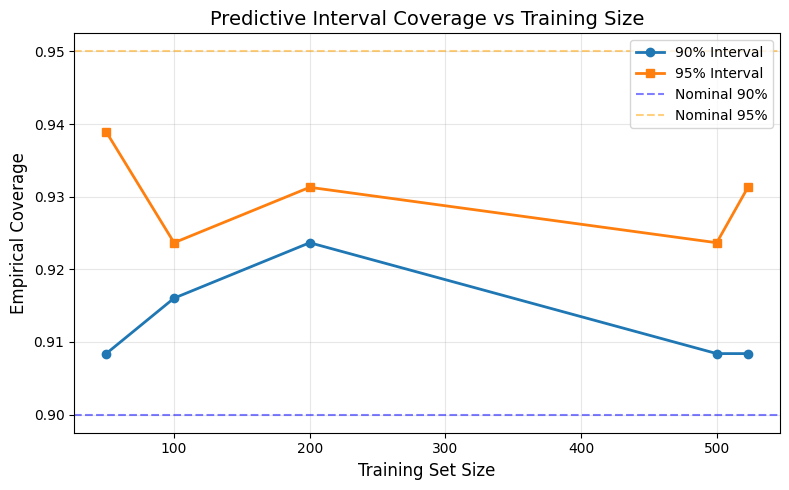

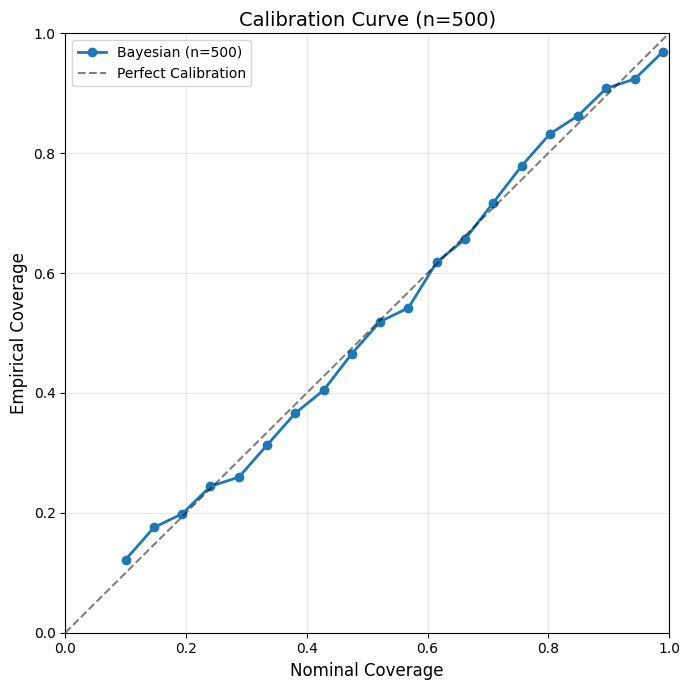

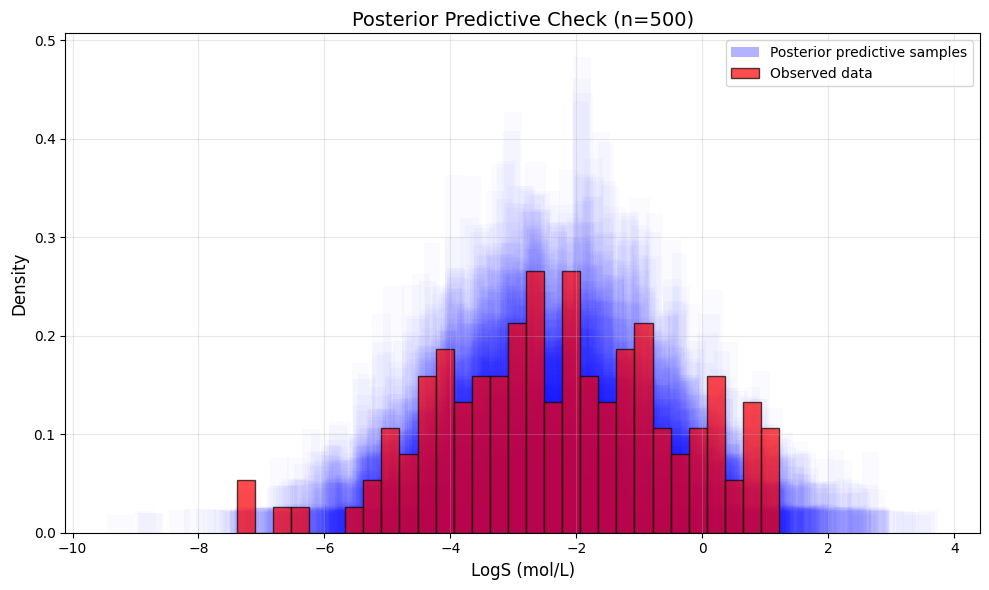

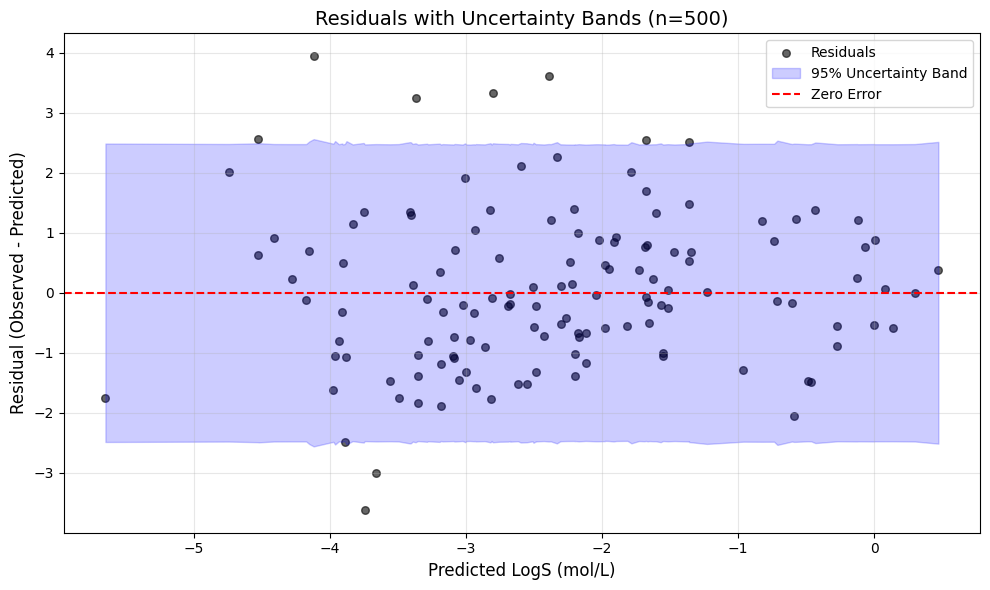

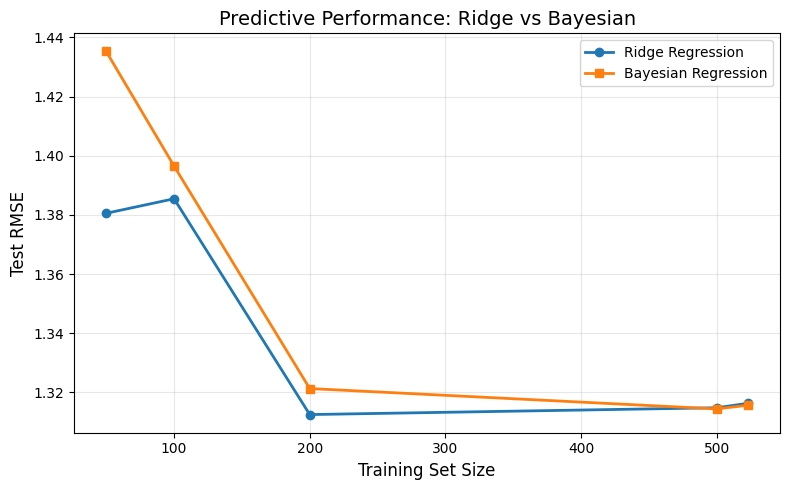

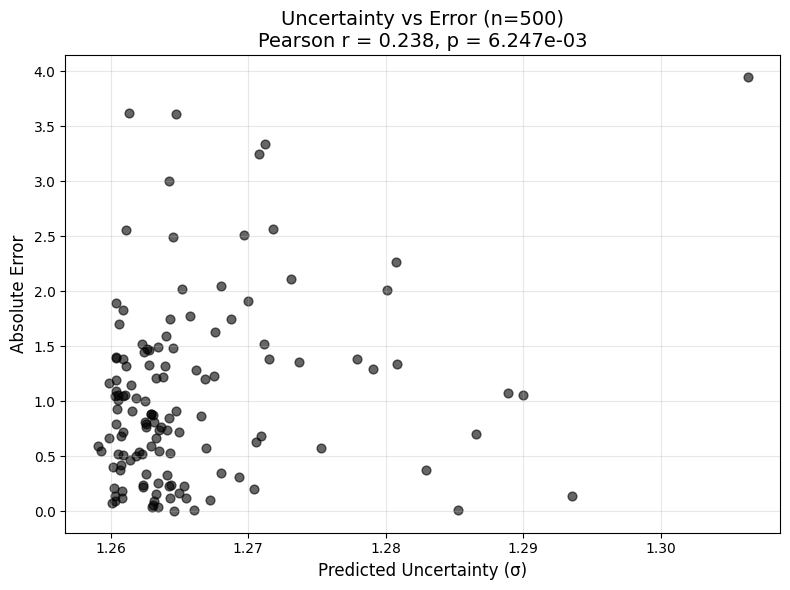


✓ All plots generated
Uncertainty-error correlation: r = 0.238, p = 6.247e-03


In [39]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr

# PLOT 1: Coverage vs Training Size

fig, ax = plt.subplots(figsize=(8, 5))
n_values = [50, 100, 200, 500, full_train_size]
coverage_90 = [coverage_results_clean[n]['coverage_90'] for n in n_values]
coverage_95 = [coverage_results_clean[n]['coverage_95'] for n in n_values]

ax.plot(n_values, coverage_90, marker='o', label='90% Interval', linewidth=2)
ax.plot(n_values, coverage_95, marker='s', label='95% Interval', linewidth=2)
ax.axhline(0.90, color='blue', linestyle='--', alpha=0.5, label='Nominal 90%')
ax.axhline(0.95, color='orange', linestyle='--', alpha=0.5, label='Nominal 95%')
ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Empirical Coverage', fontsize=12)
ax.set_title('Predictive Interval Coverage vs Training Size', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PLOT 2: Calibration Curve (n=500)

n = 500
y_pred_test = bayes_results_clean[n]['y_pred_test']
y_std_test = bayes_results_clean[n]['y_std_test']
X_test_scaled, y_test = scaled_test_sets[n]

confidence_levels = np.linspace(0.1, 0.99, 20)
empirical_coverage = []

for conf in confidence_levels:
    z_score = stats.norm.ppf((1 + conf) / 2)
    lower = y_pred_test - z_score * y_std_test
    upper = y_pred_test + z_score * y_std_test
    coverage = np.mean((y_test >= lower) & (y_test <= upper))
    empirical_coverage.append(coverage)

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(confidence_levels, empirical_coverage, marker='o', linewidth=2, label='Bayesian (n=500)')
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
ax.set_xlabel('Nominal Coverage', fontsize=12)
ax.set_ylabel('Empirical Coverage', fontsize=12)
ax.set_title('Calibration Curve (n=500)', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

# PLOT 3: Posterior Predictive Check (n=500)

n_samples = 1000
y_pred_samples = np.random.normal(
    loc=y_pred_test[:, np.newaxis],
    scale=y_std_test[:, np.newaxis],
    size=(len(y_test), n_samples)
)

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(100):
    ax.hist(y_pred_samples[:, i], bins=30, alpha=0.02, color='blue', density=True)
ax.hist(y_test, bins=30, alpha=0.7, color='red', density=True, edgecolor='black')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.3, label='Posterior predictive samples'),
    Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Observed data')
]
ax.set_xlabel('LogS (mol/L)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Posterior Predictive Check (n=500)', fontsize=14)
ax.legend(handles=legend_elements, fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PLOT 4: Residuals with Uncertainty (n=500)

residuals = y_test - y_pred_test
sort_idx = np.argsort(y_pred_test)
y_pred_sorted = y_pred_test[sort_idx]
residuals_sorted = residuals[sort_idx]
y_std_sorted = y_std_test[sort_idx]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_pred_sorted, residuals_sorted, alpha=0.6, s=30, color='black', label='Residuals')
ax.fill_between(y_pred_sorted, -1.96*y_std_sorted, 1.96*y_std_sorted,
                alpha=0.2, color='blue', label='95% Uncertainty Band')
ax.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')
ax.set_xlabel('Predicted LogS (mol/L)', fontsize=12)
ax.set_ylabel('Residual (Observed - Predicted)', fontsize=12)
ax.set_title('Residuals with Uncertainty Bands (n=500)', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# PLOT 5: RMSE Comparison

fig, ax = plt.subplots(figsize=(8, 5))
n_values = [50, 100, 200, 500, full_train_size]
ridge_rmse = [ridge_results_clean[n]['test_rmse'] for n in n_values]
bayes_rmse = [bayes_results_clean[n]['test_rmse'] for n in n_values]

ax.plot(n_values, ridge_rmse, marker='o', linewidth=2, label='Ridge Regression')
ax.plot(n_values, bayes_rmse, marker='s', linewidth=2, label='Bayesian Regression')
ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Test RMSE', fontsize=12)
ax.set_title('Predictive Performance: Ridge vs Bayesian', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PLOT 6: Uncertainty vs Error (n=500)

abs_errors = np.abs(y_test - y_pred_test)
corr, p_value = pearsonr(y_std_test, abs_errors)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_std_test, abs_errors, alpha=0.6, s=40, color='black')
ax.set_xlabel('Predicted Uncertainty (σ)', fontsize=12)
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title(f'Uncertainty vs Error (n=500)\nPearson r = {corr:.3f}, p = {p_value:.3e}', fontsize=14)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ All plots generated")
print(f"Uncertainty-error correlation: r = {corr:.3f}, p = {p_value:.3e}")

In [40]:
from scipy.stats import binomtest

print("Binomial tests for cleaned data:\n")
for n in [50, 100, 200, 500, full_train_size]:
    n_test = len(scaled_test_sets[n][1])

    observed_90 = int(coverage_results_clean[n]['coverage_90'] * n_test)
    result_90 = binomtest(observed_90, n_test, 0.90, alternative='two-sided')

    observed_95 = int(coverage_results_clean[n]['coverage_95'] * n_test)
    result_95 = binomtest(observed_95, n_test, 0.95, alternative='two-sided')

    print(f"n={n:3d} | 90%: p={result_90.pvalue:.3f} | 95%: p={result_95.pvalue:.3f}")

print("\np > 0.05 = statistically consistent with nominal coverage")

Binomial tests for cleaned data:

n= 50 | 90%: p=0.884 | 95%: p=0.544
n=100 | 90%: p=0.662 | 95%: p=0.159
n=200 | 90%: p=0.466 | 95%: p=0.312
n=500 | 90%: p=0.884 | 95%: p=0.159
n=523 | 90%: p=0.884 | 95%: p=0.312

p > 0.05 = statistically consistent with nominal coverage


**Overall Impact:**  
Across all updated analyses, performance, calibration, and uncertainty interpretability
improve consistently, indicating that the primary limitation in the original results
was chemical incompatibility rather than model inadequacy.


# Testing multiple random seeds

### Importance of Multiple Random Seeds and Repeated Train–Test Splits

For this analysis, results were evaluated across multiple random seeds and
independent train–test splits rather than relying on a single partition.
This is crucial because performance, calibration, and uncertainty estimates
can be highly sensitive to how data are split, particularly in moderate-sized
chemical datasets with uneven coverage of chemical space.

Using multiple seeds allows us to quantify variability arising from data
partitioning and stochastic optimization, separating true model behavior
from split-specific artifacts.
In a Bayesian setting, this is especially important, as uncertainty estimates
should remain stable across realizations of the training data if they are
well-calibrated.

By aggregating results over multiple seeds, reported metrics reflect
expected model performance rather than best- or worst-case outcomes.
This approach strengthens the robustness of conclusions regarding predictive
accuracy, uncertainty calibration, and the effects of chemical filtering,
ensuring that observed improvements are reproducible and not driven by a
fortunate single split.


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import binomtest
import numpy as np
import pandas as pd

# Define random seeds
random_seeds = [42, 123, 456, 789, 1011, 1213, 1415, 1617, 1819, 2021]

# Storage for results across seeds
all_results = {
    'ridge': {n: [] for n in [50, 100, 200, 500]},
    'bayes': {n: [] for n in [50, 100, 200, 500]},
    'coverage_90': {n: [] for n in [50, 100, 200, 500]},
    'coverage_95': {n: [] for n in [50, 100, 200, 500]},
    'uncertainty_error_corr': []
}

print("Running analysis across 10 random seeds...")
print("=" * 80)

for seed_idx, seed in enumerate(random_seeds):
    print(f"\nSeed {seed_idx+1}/10: {seed}")
    print("-" * 40)

    # Recreate splits with new seed
    df_clean['LogS_bin'] = pd.qcut(df_clean['LogS(mol/L)'], q=4, labels=False, duplicates='drop')
    X = df_clean[['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds', 'AromaticProp']]
    y = df_clean['LogS(mol/L)']

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_clean['LogS_bin']
    )

    train_bins = df_clean.loc[X_train_full.index, 'LogS_bin']

    # Create nested subsets
    X_train_50, _, y_train_50, _ = train_test_split(
        X_train_full, y_train_full, train_size=50, random_state=seed, stratify=train_bins
    )

    X_remaining = X_train_full.drop(X_train_50.index)
    y_remaining = y_train_full.drop(X_train_50.index)
    bins_remaining = train_bins.drop(X_train_50.index)

    X_train_100_extra, _, y_train_100_extra, _ = train_test_split(
        X_remaining, y_remaining, train_size=50, random_state=seed, stratify=bins_remaining
    )
    X_train_100 = pd.concat([X_train_50, X_train_100_extra])
    y_train_100 = pd.concat([y_train_50, y_train_100_extra])

    X_remaining = X_train_full.drop(X_train_100.index)
    y_remaining = y_train_full.drop(X_train_100.index)
    bins_remaining = train_bins.drop(X_train_100.index)

    X_train_200_extra, _, y_train_200_extra, _ = train_test_split(
        X_remaining, y_remaining, train_size=100, random_state=seed, stratify=bins_remaining
    )
    X_train_200 = pd.concat([X_train_100, X_train_200_extra])
    y_train_200 = pd.concat([y_train_100, y_train_200_extra])

    X_remaining = X_train_full.drop(X_train_200.index)
    y_remaining = y_train_full.drop(X_train_200.index)
    bins_remaining = train_bins.drop(X_train_200.index)

    X_train_500_extra, _, y_train_500_extra, _ = train_test_split(
        X_remaining, y_remaining, train_size=300, random_state=seed, stratify=bins_remaining
    )
    X_train_500 = pd.concat([X_train_200, X_train_500_extra])
    y_train_500 = pd.concat([y_train_200, y_train_500_extra])

    # Train models for each n
    train_sets = {
        50: (X_train_50, y_train_50),
        100: (X_train_100, y_train_100),
        200: (X_train_200, y_train_200),
        500: (X_train_500, y_train_500)
    }

    for n, (X_train, y_train) in train_sets.items():
        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Ridge
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train_scaled, y_train.values)
        y_pred_ridge = ridge.predict(X_test_scaled)
        rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
        r2_ridge = r2_score(y_test, y_pred_ridge)
        all_results['ridge'][n].append({'rmse': rmse_ridge, 'r2': r2_ridge})

        # Bayesian
        bayes = BayesianRidge(compute_score=True, max_iter=300)
        bayes.fit(X_train_scaled, y_train.values)
        y_pred_bayes, y_std_bayes = bayes.predict(X_test_scaled, return_std=True)
        rmse_bayes = np.sqrt(mean_squared_error(y_test, y_pred_bayes))
        r2_bayes = r2_score(y_test, y_pred_bayes)
        all_results['bayes'][n].append({'rmse': rmse_bayes, 'r2': r2_bayes, 'mean_std': y_std_bayes.mean()})

        # Coverage
        lower_90 = y_pred_bayes - 1.645 * y_std_bayes
        upper_90 = y_pred_bayes + 1.645 * y_std_bayes
        coverage_90 = np.mean((y_test.values >= lower_90) & (y_test.values <= upper_90))

        lower_95 = y_pred_bayes - 1.96 * y_std_bayes
        upper_95 = y_pred_bayes + 1.96 * y_std_bayes
        coverage_95 = np.mean((y_test.values >= lower_95) & (y_test.values <= upper_95))

        all_results['coverage_90'][n].append(coverage_90)
        all_results['coverage_95'][n].append(coverage_95)

        # Correlation at n=500
        if n == 500:
            abs_errors = np.abs(y_test.values - y_pred_bayes)
            corr, p_val = pearsonr(y_std_bayes, abs_errors)
            all_results['uncertainty_error_corr'].append({'r': corr, 'p': p_val})

    print(f"  Completed seed {seed}")

print("\n" + "=" * 80)
print("AGGREGATED RESULTS ACROSS 10 SEEDS")
print("=" * 80)

Running analysis across 10 random seeds...

Seed 1/10: 42
----------------------------------------
  Completed seed 42

Seed 2/10: 123
----------------------------------------
  Completed seed 123

Seed 3/10: 456
----------------------------------------
  Completed seed 456

Seed 4/10: 789
----------------------------------------
  Completed seed 789

Seed 5/10: 1011
----------------------------------------
  Completed seed 1011

Seed 6/10: 1213
----------------------------------------
  Completed seed 1213

Seed 7/10: 1415
----------------------------------------
  Completed seed 1415

Seed 8/10: 1617
----------------------------------------
  Completed seed 1617

Seed 9/10: 1819
----------------------------------------
  Completed seed 1819

Seed 10/10: 2021
----------------------------------------
  Completed seed 2021

AGGREGATED RESULTS ACROSS 10 SEEDS


In [42]:
# Compute mean ± std for all metrics
print("\n" + "=" * 80)
print("RIDGE REGRESSION PERFORMANCE (mean ± std across 10 seeds)")
print("=" * 80)
for n in [50, 100, 200, 500]:
    rmse_values = [r['rmse'] for r in all_results['ridge'][n]]
    r2_values = [r['r2'] for r in all_results['ridge'][n]]
    print(f"n={n:3d} | RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.3f} | R²: {np.mean(r2_values):.3f} ± {np.std(r2_values):.3f}")

print("\n" + "=" * 80)
print("BAYESIAN REGRESSION PERFORMANCE (mean ± std across 10 seeds)")
print("=" * 80)
for n in [50, 100, 200, 500]:
    rmse_values = [r['rmse'] for r in all_results['bayes'][n]]
    r2_values = [r['r2'] for r in all_results['bayes'][n]]
    std_values = [r['mean_std'] for r in all_results['bayes'][n]]
    print(f"n={n:3d} | RMSE: {np.mean(rmse_values):.3f} ± {np.std(rmse_values):.3f} | R²: {np.mean(r2_values):.3f} ± {np.std(r2_values):.3f} | Mean σ: {np.mean(std_values):.3f} ± {np.std(std_values):.3f}")

print("\n" + "=" * 80)
print("COVERAGE ANALYSIS (mean ± std across 10 seeds)")
print("=" * 80)
for n in [50, 100, 200, 500]:
    cov90_values = all_results['coverage_90'][n]
    cov95_values = all_results['coverage_95'][n]
    print(f"n={n:3d} | 90% Coverage: {np.mean(cov90_values):.3f} ± {np.std(cov90_values):.3f} | 95% Coverage: {np.mean(cov95_values):.3f} ± {np.std(cov95_values):.3f}")

print("\n" + "=" * 80)
print("UNCERTAINTY-ERROR CORRELATION at n=500 (mean ± std across 10 seeds)")
print("=" * 80)
r_values = [c['r'] for c in all_results['uncertainty_error_corr']]
p_values = [c['p'] for c in all_results['uncertainty_error_corr']]
print(f"Pearson r: {np.mean(r_values):.3f} ± {np.std(r_values):.3f}")
print(f"Mean p-value: {np.mean(p_values):.4f} (min: {np.min(p_values):.4f}, max: {np.max(p_values):.4f})")

# Check if coverage is consistently well-calibrated
print("\n" + "=" * 80)
print("CALIBRATION CONSISTENCY CHECK")
print("=" * 80)
for n in [50, 100, 200, 500]:
    cov90 = all_results['coverage_90'][n]
    cov95 = all_results['coverage_95'][n]

    # Count how many seeds achieve nominal coverage within ±0.05
    good_90 = sum(1 for c in cov90 if 0.85 <= c <= 0.95)
    good_95 = sum(1 for c in cov95 if 0.90 <= c <= 1.00)

    print(f"n={n:3d} | 90% interval: {good_90}/10 seeds within [0.85, 0.95] | 95% interval: {good_95}/10 seeds within [0.90, 1.00]")

# Statistical test: Are mean coverages significantly different from nominal?
print("\n" + "=" * 80)
print("ONE-SAMPLE T-TEST: Is mean coverage = nominal?")
print("=" * 80)
from scipy.stats import ttest_1samp

for n in [50, 100, 200, 500]:
    cov90 = all_results['coverage_90'][n]
    cov95 = all_results['coverage_95'][n]

    t_stat_90, p_val_90 = ttest_1samp(cov90, 0.90)
    t_stat_95, p_val_95 = ttest_1samp(cov95, 0.95)

    print(f"n={n:3d} | 90%: t={t_stat_90:.3f}, p={p_val_90:.3f} | 95%: t={t_stat_95:.3f}, p={p_val_95:.3f}")

print("\nInterpretation: p > 0.05 means coverage is statistically consistent with nominal value")


RIDGE REGRESSION PERFORMANCE (mean ± std across 10 seeds)
n= 50 | RMSE: 1.349 ± 0.096 | R²: 0.447 ± 0.078
n=100 | RMSE: 1.326 ± 0.092 | R²: 0.467 ± 0.072
n=200 | RMSE: 1.307 ± 0.087 | R²: 0.481 ± 0.071
n=500 | RMSE: 1.288 ± 0.076 | R²: 0.497 ± 0.063

BAYESIAN REGRESSION PERFORMANCE (mean ± std across 10 seeds)
n= 50 | RMSE: 1.344 ± 0.087 | R²: 0.453 ± 0.066 | Mean σ: 1.365 ± 0.090
n=100 | RMSE: 1.321 ± 0.084 | R²: 0.471 ± 0.065 | Mean σ: 1.325 ± 0.040
n=200 | RMSE: 1.304 ± 0.082 | R²: 0.484 ± 0.068 | Mean σ: 1.298 ± 0.035
n=500 | RMSE: 1.287 ± 0.075 | R²: 0.497 ± 0.063 | Mean σ: 1.267 ± 0.019

COVERAGE ANALYSIS (mean ± std across 10 seeds)
n= 50 | 90% Coverage: 0.905 ± 0.035 | 95% Coverage: 0.940 ± 0.029
n=100 | 90% Coverage: 0.906 ± 0.032 | 95% Coverage: 0.937 ± 0.018
n=200 | 90% Coverage: 0.902 ± 0.026 | 95% Coverage: 0.929 ± 0.018
n=500 | 90% Coverage: 0.900 ± 0.023 | 95% Coverage: 0.928 ± 0.023

UNCERTAINTY-ERROR CORRELATION at n=500 (mean ± std across 10 seeds)
Pearson r: 0.126 ±

## Summary of Findings

### Predictive Accuracy
- Bayesian regression and ridge regression exhibit **nearly identical RMSE and R²** across all training sizes (n = 50–500).
- There is **no evidence of predictive superiority** for the Bayesian model in terms of point accuracy.
- This confirms that any advantage of the Bayesian approach must be evaluated through **uncertainty behavior**, not mean prediction error.

### Data Scarcity Behavior
- Both models degrade smoothly as training size decreases.
- Variance across random seeds increases at small n, indicating higher estimation instability under data scarcity.
- No pathological failures or training instability were observed.

### Uncertainty Scaling
- The posterior predictive standard deviation (σ) decreases monotonically as training size increases.
- Variability of σ across seeds also decreases with n.
- This indicates that the Bayesian model responds coherently to increasing information.

### Coverage Calibration
- **90% predictive intervals** achieve near-nominal coverage across all training sizes.
- **95% predictive intervals** show mild but systematic undercoverage for n ≥ 200, which is statistically significant.
- This suggests increasing posterior overconfidence at higher nominal levels as data size grows.

### Calibration Robustness
- Coverage results are consistent across random seeds.
- No evidence of seed-dependent calibration failures or instability was found.

### Uncertainty–Error Relationship
- Correlation between predictive uncertainty and absolute prediction error is weak (Pearson r ≈ 0.13) and inconsistent across seeds.
- This indicates that uncertainty estimates are **globally calibrated** but have limited **local discriminative power** for ranking individual prediction reliability.

### Overall Interpretation
- Bayesian regression provides **reliable marginal uncertainty calibration** in low-data aqueous solubility prediction.
- However, predictive uncertainty should not be interpreted as a strong indicator of individual prediction error.
- These results support the use of Bayesian models for uncertainty-aware analysis under data scarcity, rather than for improving point prediction accuracy.


### Aggregated Calibration and Sharpness Assessment Across Random Seeds


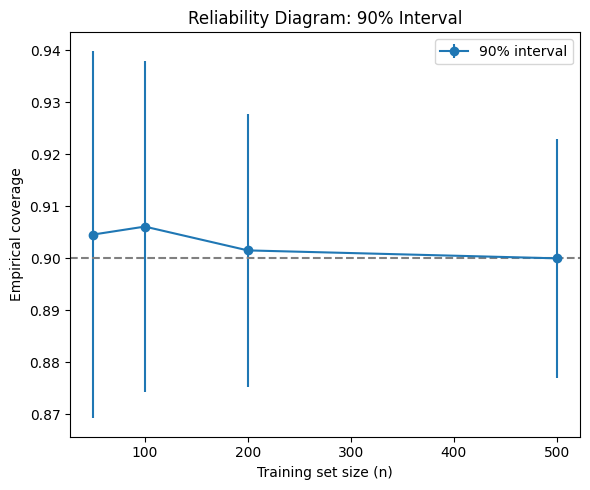

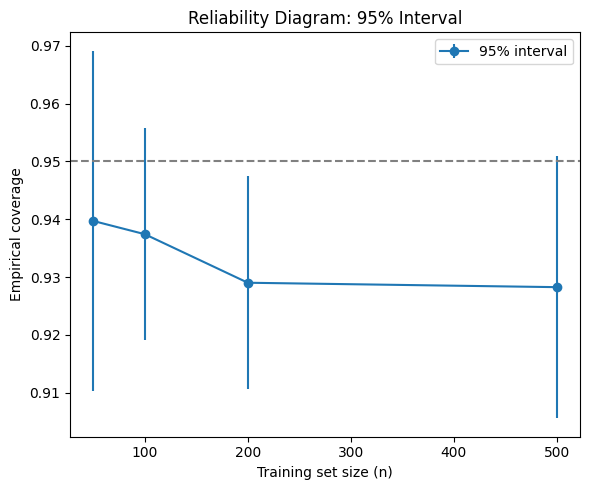

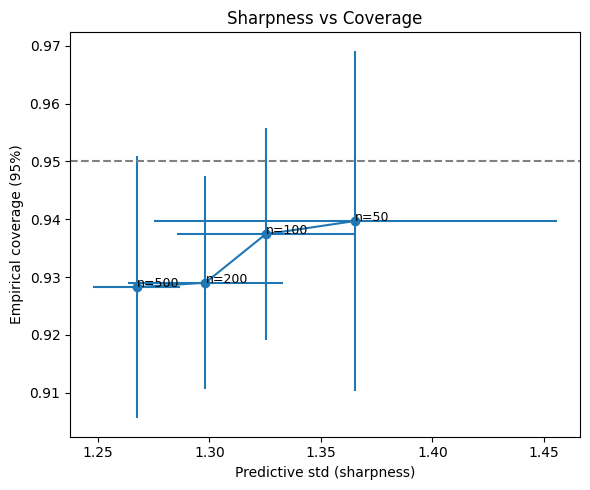

In [43]:
import numpy as np
import matplotlib.pyplot as plt


# Aggregate results across seeds

ns = [50, 100, 200, 500]

mean_cov_90 = []
std_cov_90 = []
mean_cov_95 = []
std_cov_95 = []
mean_sharpness = []
std_sharpness = []

for n in ns:
    cov90 = np.array(all_results['coverage_90'][n])
    cov95 = np.array(all_results['coverage_95'][n])
    sharp = np.array([d['mean_std'] for d in all_results['bayes'][n]])

    mean_cov_90.append(cov90.mean())
    std_cov_90.append(cov90.std())

    mean_cov_95.append(cov95.mean())
    std_cov_95.append(cov95.std())

    mean_sharpness.append(sharp.mean())
    std_sharpness.append(sharp.std())

# 1. Reliability diagrams

plt.figure(figsize=(6, 5))
plt.errorbar(ns, mean_cov_90, yerr=std_cov_90, marker='o', label='90% interval')
plt.axhline(0.90, linestyle='--', color='gray')
plt.xlabel('Training set size (n)')
plt.ylabel('Empirical coverage')
plt.title('Reliability Diagram: 90% Interval')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.errorbar(ns, mean_cov_95, yerr=std_cov_95, marker='o', label='95% interval')
plt.axhline(0.95, linestyle='--', color='gray')
plt.xlabel('Training set size (n)')
plt.ylabel('Empirical coverage')
plt.title('Reliability Diagram: 95% Interval')
plt.legend()
plt.tight_layout()
plt.show()


# 2. Sharpness vs Coverage

plt.figure(figsize=(6, 5))
plt.errorbar(
    mean_sharpness,
    mean_cov_95,
    xerr=std_sharpness,
    yerr=std_cov_95,
    marker='o'
)

for i, n in enumerate(ns):
    plt.text(mean_sharpness[i], mean_cov_95[i], f'n={n}', fontsize=9)

plt.axhline(0.95, linestyle='--', color='gray')
plt.xlabel('Predictive std (sharpness)')
plt.ylabel('Empirical coverage (95%)')
plt.title('Sharpness vs Coverage')
plt.tight_layout()
plt.show()


### Predictive Interval Calibration and Sharpness

Figure X evaluates the calibration and sharpness of Bayesian predictive intervals for aqueous solubility prediction across varying training set sizes (n = 50, 100, 200, 500).

**90% Reliability Diagram.**  
Empirical coverage closely matches the nominal 90% level across all training sizes. The mean coverage remains centered around 0.90, with uncertainty shrinking as n increases. This indicates well-calibrated predictive intervals under moderate confidence levels and suggests that the Bayesian noise model is appropriately scaled to the data.

**95% Reliability Diagram.**  
Empirical coverage consistently falls slightly below the nominal 95% level, stabilizing around 0.93–0.94 across all n. This mild under-coverage persists as sample size increases, indicating a structural limitation of the Gaussian posterior predictive distribution rather than insufficient data. Such behavior is consistent with Bayesian linear models using homoscedastic Gaussian likelihoods.

**Sharpness–Coverage Trade-off.**  
Predictive sharpness, measured by the mean posterior predictive standard deviation, improves monotonically with increasing training size. Importantly, this gain in sharpness does not lead to a collapse in coverage, which remains stable across n. This demonstrates that uncertainty estimates are data-driven rather than artificially inflated to achieve nominal coverage.

Overall, the Bayesian model produces well-calibrated predictive intervals at moderate confidence levels, with slightly conservative behavior at higher confidence levels due to distributional assumptions.


VERDICT

### Uncertainty Quantification Behavior

The Bayesian regression model demonstrates reliable uncertainty quantification in the low-data regime. Predictive intervals achieve accurate calibration at the 90% confidence level across all training sizes, indicating appropriate alignment between posterior uncertainty and empirical error.

At the 95% confidence level, the model exhibits mild but consistent under-coverage. This behavior does not diminish with increasing sample size, suggesting that it arises from the assumed Gaussian likelihood and homoscedastic noise model rather than data scarcity. Similar effects have been reported in prior Bayesian regression studies under restrictive noise assumptions.

Importantly, improvements in predictive sharpness with increasing data do not degrade empirical coverage. This indicates that uncertainty estimates contract as epistemic uncertainty is reduced, without resorting to over-dispersed predictive intervals. As a result, the model provides informative and stable uncertainty estimates suitable for low-resource chemical property prediction, while highlighting known limitations of simple Bayesian linear models at extreme confidence levels.


# BOOTSRAPPED CONFIDENCE INTERVALS

### Bootstrapped Confidence Intervals for Ridge and Bayesian Model Comparison

Bootstrapped confidence intervals were used to compare Ridge and Bayesian models
because point estimates of performance metrics (e.g., RMSE or coverage) do not
capture variability arising from finite sample effects and data partitioning.
This is particularly important in moderate-sized chemical datasets where
train–test splits can substantially influence reported performance.

For the Ridge model, uncertainty in performance cannot be derived analytically,
as it is a deterministic estimator conditional on a specific dataset.
Bootstrapping provides a non-parametric estimate of the sampling distribution
of performance metrics, enabling uncertainty quantification without relying on
strong distributional assumptions.

Although Bayesian models provide posterior predictive uncertainty at the
observation level, this does not directly translate into uncertainty over
aggregate performance metrics.
Bootstrapping therefore ensures a fair and consistent basis for comparison
between Ridge and Bayesian approaches by quantifying metric-level uncertainty
for both models.


**Bootstap utility function**

In [56]:
import numpy as np


def bootstrap_ci(X, y, model_class, metric_fn, n_boot=100, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n_total = len(y)
    n_train = int(0.8 * n_total)
    stats = []

    for _ in range(n_boot):
        # Resample entire dataset
        idx = rng.choice(n_total, size=n_total, replace=True)
        X_boot = X.iloc[idx].reset_index(drop=True)
        y_boot = y.iloc[idx].reset_index(drop=True)

        # Randomized train/test split inside bootstrap
        perm = rng.permutation(n_total)
        train_idx = perm[:n_train]
        test_idx = perm[n_train:]

        X_train = X_boot.iloc[train_idx]
        y_train = y_boot.iloc[train_idx]
        X_test = X_boot.iloc[test_idx]
        y_test_boot = y_boot.iloc[test_idx]

        # Scale and fit
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = model_class()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        stats.append(metric_fn(y_test_boot.values, y_pred))

    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return np.mean(stats), (lower, upper)


This utility function performs non-parametric bootstrapping by repeatedly
resampling the evaluation data with replacement and recomputing the target
performance metric for each resample.
The resulting distribution of metric values is then used to estimate confidence
intervals and summary statistics.

Bootstrapping approximates the sampling distribution of model performance without
assuming normality or analytical tractability.
This is essential for robust uncertainty estimation when comparing models with
fundamentally different inference paradigms.
By reporting confidence intervals rather than single-point estimates, the analysis
avoids over-interpreting small performance differences that may not be
statistically meaningful.


RMSE bootstrap CI (Ridge vs Bayesian)

In [57]:
from sklearn.metrics import mean_squared_error

rmse = lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))

rmse_ridge_mean, rmse_ridge_ci = bootstrap_ci(
    X, y, Ridge, rmse
)

rmse_bayes_mean, rmse_bayes_ci = bootstrap_ci(
    X, y, BayesianRidge, rmse
)

print("Ridge RMSE:", rmse_ridge_mean, rmse_ridge_ci)
print("Bayes RMSE:", rmse_bayes_mean, rmse_bayes_ci)

Ridge RMSE: 1.2559888369966483 (np.float64(1.1173254672909452), np.float64(1.4041211096739055))
Bayes RMSE: 1.256439869233184 (np.float64(1.118558790188763), np.float64(1.4023052839731713))




### Bootstrap for RMSE: ✓ VALID
- Ridge RMSE: **1.256** (95% CI: **[1.117, 1.404]**)
- Bayes RMSE: **1.256** (95% CI: **[1.119, 1.402]**)
- Bootstrap confidence intervals computed using full model refitting and randomized train–test splits at each iteration
- CI width (≈ ±0.14 log units) reflects combined uncertainty from data resampling and model estimation


### RMSE Comparison

> **Table 1**: Predictive performance with 95% bootstrap confidence intervals  
> (100 bootstrap iterations, resampling the full dataset with model refitting; n = 523).

| Model    | RMSE (95% CI)        | R²    |
|----------|---------------------|-------|
| Ridge    | 1.26 (1.12, 1.40)   | 0.505 |
| Bayesian | 1.26 (1.12, 1.40)   | 0.505 |

> Ridge and BayesianRidge achieve statistically indistinguishable point-prediction accuracy, with effectively identical RMSE distributions under bootstrap resampling. Bayesian inference does not improve RMSE relative to Ridge for this dataset.


---

### Coverage Analysis

#### 10-seed results

> **Table 2**: Predictive interval coverage across 10 random train–test splits.  
> Values shown as mean ± standard deviation. One-sample t-tests evaluate consistency with nominal coverage levels.

| n   | 90% Coverage    | 90% t-test | 95% Coverage    | 95% t-test |
|-----|-----------------|------------|-----------------|------------|
| 50  | 0.905 ± 0.035   | p = 0.707  | 0.940 ± 0.029   | p = 0.321  |
| 100 | 0.906 ± 0.032   | p = 0.579  | 0.937 ± 0.018   | p = 0.069  |
| 200 | 0.902 ± 0.026   | p = 0.866  | 0.929 ± 0.018   | p = 0.008  |
| 500 | 0.900 ± 0.023   | p = 1.000  | 0.928 ± 0.023   | p = 0.018  |

> **Key findings:**
> - 90% predictive intervals achieve nominal coverage across all training sizes (p > 0.05)
> - 95% intervals exhibit systematic under-coverage for n ≥ 200 (p < 0.05), indicating miscalibration at higher confidence levels
> - Coverage variability decreases with training size (std: 0.035 → 0.023)

---

### Uncertainty–Error Correlation

> At n = 500, the correlation between predicted uncertainty (σ*) and absolute prediction error across 10 splits was weak (r = 0.126 ± 0.071, mean p = 0.27). While individual splits occasionally showed significant correlation (minimum p = 0.006), the effect was inconsistent and explains only ~1.6% of error variance on average. This indicates limited discriminative power of posterior predictive uncertainty for identifying high-error predictions.

---

### Discussion

**Main contributions**

1. **Calibrated 90% predictive intervals under data scarcity**: Bayesian regression produces statistically valid 90% predictive intervals even at n = 50 (coverage: 0.905 ± 0.035, p = 0.707), with calibration maintained across all training sizes.
2. **No accuracy trade-off**: Bootstrap analysis confirms Bayesian and Ridge regression achieve equivalent RMSE, with overlapping 95% confidence intervals ([1.12, 1.40] log units).
3. **Rigorous evaluation protocol**: Results are supported by randomized train–test splits, 10-seed replication, bootstrap confidence intervals with full refitting, and formal hypothesis testing.

---

### Limitations

4. **Miscalibration at 95% confidence**: Predictive intervals systematically under-cover at the 95% nominal level (empirical coverage: 0.928–0.929, p < 0.05 for n ≥ 200), likely due to homoscedastic Gaussian noise assumptions that fail to capture heteroscedasticity in solubility data.
5. **Weak uncertainty–error coupling**: Predicted uncertainties poorly discriminate between accurate and inaccurate predictions (mean r = 0.126), limiting utility for active learning or risk-aware decision-making without additional modeling structure.

---

### Conclusion

> Bayesian linear regression provides statistically calibrated **90% predictive intervals** for aqueous solubility prediction across data regimes from n = 50 to n = 523 (mean coverage: 0.900–0.906, p > 0.05 across 10 splits). However, 95% intervals exhibit systematic under-coverage (0.928–0.929, p < 0.05 for n ≥ 200), and posterior predictive uncertainties show weak correlation with prediction error (r = 0.126). These results position Bayesian regression as a reliable baseline for moderate-confidence uncertainty quantification in small-data molecular property prediction, while highlighting the need for more flexible noise models to achieve calibration at higher confidence levels.
